## Compile the redox potentials
We want to see what the energy differences for different methods are


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress, siegelslopes
from ase.db import connect
import pandas as pd
import numpy as np

## Load the Database into Pandas
Get the energies for each system for each CP2K setting

In [2]:
example_molecules = pd.read_csv('../data/example_molecules.csv')

In [3]:
mol_props = example_molecules.set_index('inchi_key').to_dict('index')

In [4]:
data = []
for psolver in ['mt', 'wavelet', 'mt-gpu']:
    with connect(f'{psolver}/data.db') as db:
        for row in db.select(''):
            record = row.key_value_pairs.copy()
            record['basis_set'] = record['basis_set'].upper()
            record['n_electrons'] = mol_props[record['inchi_key']]['n_electrons']
            record['energy'] = row.energy
            record['solver'] = psolver
            data.append(record)
data = pd.DataFrame(data)
print(f'Loaded {len(data)} computations')

Loaded 136 computations


## Compute the redox potentials
Get the energy differences between different stats

In [5]:
method_keys = ['solver', 'basis_set', 'xc', 'cutoff', 'buffer']
records = []
for lid, (level, subset) in enumerate(data.groupby(method_keys)):
    method_desc = dict(zip(method_keys, level))
    
    # Match states
    neutrals = subset.query('state=="neutral"')
    for state in ['oxidized', 'reduced']:
        redoxed = subset.query(f'state=="{state}"')
        merged = redoxed.merge(neutrals, on='inchi_key')
        
        # Create a record for each
        for _, row in merged.iterrows():
            record = {}
            record['inchi_key'] = row['inchi_key']
            record['state'] = state
            record['potential'] = row['energy_x'] - row['energy_y']
            record['runtime'] = row['runtime_x'] + row['runtime_y']
            record['level_id'] = lid
            record['n_electrons'] = row['n_electrons_x']
            record.update(method_desc)
            records.append(record)
records = pd.DataFrame(records)

## Compare Integrators
Determine whether wavelets or MT are a better choice

In [6]:
mt_params = {'solver': 'mt', 'cutoff': 500, 'basis_set': 'AUG-DZVP-GTH'}
wavelet_params = {'solver': 'wavelet', 'cutoff': 500, 'basis_set': 'AUG-DZVP-GTH'}

In [7]:
mt_records = records.copy()
for k, v in mt_params.items():
    mt_records = mt_records[mt_records[k] == v]
assert len(mt_records.level_id.value_counts()) == 1
print(f'Reduced to {len(mt_records)} results for MT')
mt_records.head(2)

Reduced to 8 results for MT


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer
0,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.255982,585.008532,0,6,mt,AUG-DZVP-GTH,BLYP,500,6
1,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.255982,583.011764,0,6,mt,AUG-DZVP-GTH,BLYP,500,6


In [8]:
wavelet_records = records.copy()
for k, v in wavelet_params.items():
    wavelet_records = wavelet_records[wavelet_records[k] == v]
assert len(wavelet_records.level_id.value_counts()) == 1
print(f'Reduced to {len(wavelet_records)} results for wavelet')
wavelet_records.head(2)

Reduced to 8 results for wavelet


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer
85,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.256055,708.046393,6,6,wavelet,AUG-DZVP-GTH,BLYP,500,6
86,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,9.665833,4113.525382,6,24,wavelet,AUG-DZVP-GTH,BLYP,500,6


Compare results

In [9]:
merged = mt_records.merge(wavelet_records, on=('inchi_key', 'state', 'basis_set', 'xc', 'n_electrons'))
n_basis = len(mt_records.basis_set.value_counts())

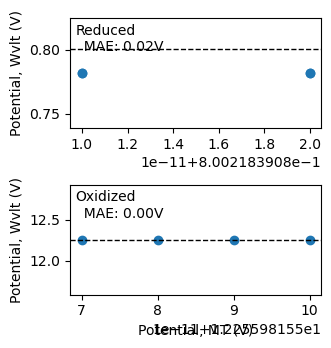

In [10]:
fig, axs = plt.subplots(2, n_basis, figsize=(3.5, 3.5))

for ax, (gid, group) in zip(axs[:, None].T, merged.groupby('basis_set')):
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = group.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
    
        a.set_ylabel('Potential, Wvlt (V)')
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, MT (V)')
    
fig.tight_layout()

/home/lward/miniconda3/envs/qcgpu/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:181: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/lward/miniconda3/envs/qcgpu/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lward/miniconda3/envs/qcgpu/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


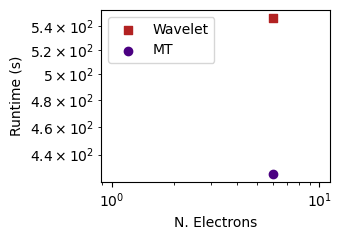

In [11]:
fig, axs = plt.subplots(1, n_basis, sharey=True, figsize=(3.5, 2.5))

for ax, (basis, group) in zip([axs], merged.groupby('basis_set')):   
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='Wavelet')
    wt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='MT')
    mt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(wt_linreg.intercept + wt_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(mt_linreg.intercept + mt_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_ylabel('Runtime (s)')
    ax.set_xlabel('N. Electrons')
    
fig.tight_layout()

MT seems to be slightly faster

## Compare CPU to GPU Implementation
Get the MT, but with a GPU-accelerated version.

In [12]:
mt_params['basis_set'] = 'DZVP-GTH'

In [13]:
gpu_params = mt_params.copy()
gpu_params['solver'] += "-gpu"

In [14]:
gpu_records = data.copy()
for k, v in gpu_params.items():
    gpu_records = gpu_records[gpu_records[k] == v]
print(f'Reduced to {len(gpu_records)} results for MT-GPU')
gpu_records.head(2)

Reduced to 36 results for MT-GPU


,inchi_key,state,runtime,basis_set,cutoff,buffer,xc,n_electrons,energy,solver
100,VNWKTOKETHGBQD-UHFFFAOYSA-N,neutral,45.741822,DZVP-GTH,500,6,BLYP,6,-218.722084,mt-gpu
101,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,195.385836,DZVP-GTH,500,6,BLYP,6,-206.586435,mt-gpu


In [15]:
cpu_records = data.copy()
for k, v in mt_params.items():
    cpu_records = cpu_records[cpu_records[k] == v]
print(f'Reduced to {len(cpu_records)} results for MT-CPU')
cpu_records.head(2)

Reduced to 36 results for MT-CPU


,inchi_key,state,runtime,basis_set,cutoff,buffer,xc,n_electrons,energy,solver
4,VNWKTOKETHGBQD-UHFFFAOYSA-N,neutral,111.685695,DZVP-GTH,500,6,BLYP,6,-218.722084,mt
5,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,495.013552,DZVP-GTH,500,6,BLYP,6,-206.586435,mt


In [16]:
merged = cpu_records.merge(gpu_records, on=('inchi_key', 'state', 'basis_set', 'xc', 'n_electrons'))
merged['speedup'] = merged['runtime_x'] / merged['runtime_y']

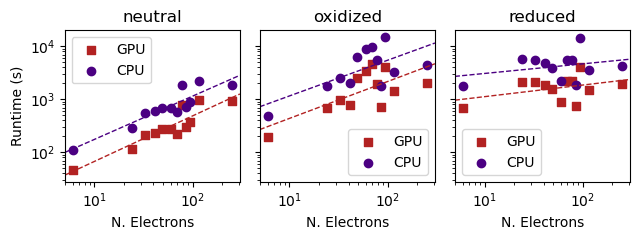

In [17]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6.5, 2.5))

for ax, (state, group) in zip(axs, merged.groupby('state')):   
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='GPU')
    wt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CPU')
    mt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_title(state)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(wt_linreg.intercept + wt_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(mt_linreg.intercept + mt_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
axs[0].set_ylabel('Runtime (s)')
    
fig.tight_layout()

In [18]:
merged.speedup.describe()

count    36.000000
mean      2.529519
std       0.301469
min       2.002601
25%       2.427743
50%       2.495880
75%       2.593431
max       3.564770
Name: speedup, dtype: float64

In [19]:
merged.groupby('state')['speedup'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
neutral,12.0,2.425844,0.154116,2.002601,2.409051,2.449552,2.497902,2.585535
oxidized,12.0,2.576711,0.377806,2.119474,2.401218,2.539015,2.627051,3.564770
reduced,12.0,2.586002,0.324116,2.212751,2.439605,2.501874,2.640648,3.483831


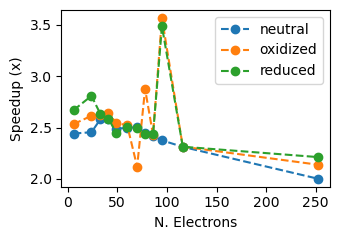

In [20]:
fig, ax = plt.subplots(1, sharey=True, figsize=(3.5, 2.5))

for state, group in merged.groupby('state'):
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.plot(subset.index, subset['speedup'], '--o', label=state)
    
# Set up the scale
ax.set_ylabel('Speedup (x)')
ax.set_xlabel('N. Electrons')
ax.legend()
    
fig.tight_layout()

Speedup does seem pretty constant around 2, maybe decreasing with system size

## Compare to NWChem
Make sure we are close to our baseline values

Get the GPU records

In [21]:
gpu_records = records.copy()
gpu_params.pop('basis_set', None)
for k, v in gpu_params.items():
    gpu_records = gpu_records[gpu_records[k] == v]
print(f'Reduced to {len(gpu_records)} results for MT-GPU')
gpu_records.head(2)

Reduced to 44 results for MT-GPU


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer
36,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.255982,237.848737,3,6,mt-gpu,AUG-DZVP-GTH,BLYP,500,6
37,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,9.666715,1075.651902,3,24,mt-gpu,AUG-DZVP-GTH,BLYP,500,6


In [22]:
chosen = gpu_records
print(f'Ran CP2K for {len(chosen.inchi_key.value_counts())} molecules')

Ran CP2K for 12 molecules


In [23]:
nwchem_results = pd.read_csv('../nwchem/nwchem-redox-potentials.csv')
print(f'Ran NWChem for {len(nwchem_results.inchi_key.value_counts())} molecules')

Ran NWChem for 12 molecules


Compare to NWChem

In [24]:
matched_basis = [('AUG-DZVP-GTH', 'aug-cc-pvdz'), ('DZVP-GTH', 'cc-pvdz')]

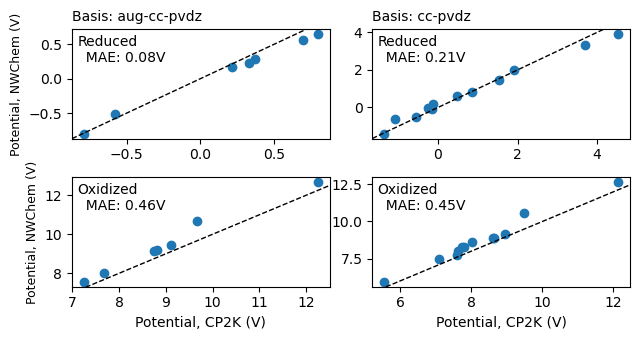

In [25]:
fig, axs = plt.subplots(2, len(matched_basis), figsize=(6.5, 3.5))

for ax, (cp2k_basis, nwc_basis) in zip(axs[:, :].T, matched_basis):
    ax[0].set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = merged.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, CP2K (V)')
    
for ax in axs[:, 0]:
    ax.set_ylabel('Potential, NWChem (V)', fontsize=9)
    
fig.tight_layout()

Compare the runtimes

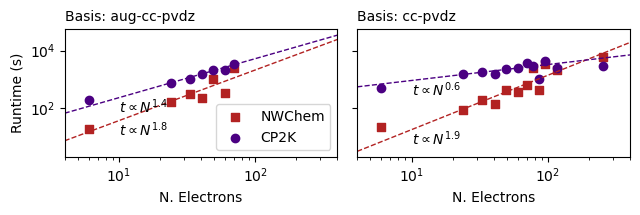

In [26]:
fig, axs = plt.subplots(1, len(matched_basis), sharey=True, sharex=True, figsize=(6.5, 2.25))

for ax, (cp2k_basis, nwc_basis) in zip(axs, matched_basis):
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    subset = merged.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='NWChem')
    nwc_linreg = siegelslopes(np.log(subset['runtime_y']), np.log(subset.index))
    ax.text(10, np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{nwc_linreg.slope:.1f}}}$', va='top')
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CP2K')
    cpk_linreg = siegelslopes(np.log(subset['runtime_x']), np.log(subset.index))
    ax.text(10, np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{cpk_linreg.slope:.1f}}}$', va='top')
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Plot the linear regressions
    ax.set_xlim([4, 400])
    ax.plot(ax.get_xlim(), np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
    ax.set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')

axs[0].set_ylabel('Runtime (s)')
axs[0].legend()
fig.tight_layout()